**GHAILAN GORDON**

Spring 2024

CS 443: Bio-inspired Machine Learning

#### Week 2: Competitive Hebbian Network

# Project 1: Hebbian Learning

This week you will implement a bio-inspired network that learns according to a competitive variant of Oja's Rule proposed by Krotov & Hopfield (2019). You will train this network on MNIST and dynamically visualize the learning process.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import time

from mnist import get_mnist

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.show()
plt.rcParams.update({'font.size': 18})

np.set_printoptions(suppress=True, precision=3)

%load_ext autoreload
%autoreload 2

2024-02-28 20:11:30.698218: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Task 2: Competitive Hebbian network

Implement the Hebbian learning network in `hebb_net.py` and test it using the cells below.

As with your contrastive network, your Competitive Hebbian network should be implemented entirely using the low-level TensorFlow API. 

In [3]:
from hebb_net import HebbNet

### 2a. Start implementing Hebbian network (`HebbNet` class)

Implement the following methods in `hebb_net.py`:
- Constructor
- `get_wts(self)`
- `set_wts(self, wts)`
- `net_in(self, x)`

The network uses the usual Dense net in:

$$\text{netIn}_{ih} = z_{ih} = \sum_{j=1}^M x_{ij} w_{jh}$$


#### Test: `net_in`

In [4]:
N, M, H = 3, 10, 6
tf.random.set_seed(0)
x = tf.random.uniform(shape=(N, M), seed=0)

net = HebbNet(M, H, k=3)
print(f'Your net_in is:\n{net.net_in(x)}\nand it should be:')
print('''[[2.169 1.905 2.051 0.644 1.762 2.311]
 [1.97  2.249 2.423 1.107 1.425 2.416]
 [2.28  2.133 2.832 1.356 1.915 3.159]]''')

Your net_in is:
[[2.169 1.905 2.051 0.644 1.762 2.311]
 [1.97  2.249 2.423 1.107 1.425 2.416]
 [2.28  2.133 2.832 1.356 1.915 3.159]]
and it should be:
[[2.169 1.905 2.051 0.644 1.762 2.311]
 [1.97  2.249 2.423 1.107 1.425 2.416]
 [2.28  2.133 2.832 1.356 1.915 3.159]]


### 2b. Hebbian network activation


The activation in the Hebbian network (`netAct`) to each sample $i$ in neuron $h$ implements a **competitive** process:

$$\text{netAct}_{ih} = f(z_{ih})  =
\begin{cases}
      1, & \text{if}\ h = argmax_h (\text{netIn}_{ih}) \text{ i.e neuron } h \text{ comes in 1st place} \\
      -\Delta, & \text{if neuron }\ h \text{ comes in } k^{\text{th}} \text{ place} \\
      0, & \text{otherwise}
\end{cases}$$

Notes about the above netAct equation:

- "1st place" refer to the neuron that achieves the highest netIn values.
- "$k^{\text{th}}$ place" refers to the neuron that achieves the $k^{\text{th}}$ highest netIn value. For example, $k=2$ refers to the "2nd place" neuron that achieves the 2nd highest netIn.
- $k^{\text{th}}$ place is defined in the usual "human-interpretable" rather than an "Python indexing" sense (i.e. $k=2$ for second place, $k=3$ for third place, etc.)

Implement the neural competition in the `net_act(self, net_in)` method then test it below.

#### Test: net_act

In [5]:
def test_net_act(x, M, H, kth_place_inhibited, inhib_value):
    '''net_act tester function'''
    tf.random.set_seed(0)
    net = HebbNet(M, H, k=kth_place_inhibited, inhib_value=inhib_value)
    net_in = net.net_in(x)
    print(f"The net_in is:\n{net_in}:")
    print(f'So your net_act is:\n{net.net_act(net_in)}\nand it should be:')

In [6]:
# Simplest test
print('Test 1: Simplest test with 1 sample and no inhibition (only winner-take-all)')
x = np.array([[1, 2, 0]])
test_net_act(x, M=3, H=5, kth_place_inhibited=2, inhib_value=0)
print('[[0. 0. 1. 0. 0.]]')

Test 1: Simplest test with 1 sample and no inhibition (only winner-take-all)
The net_in is:
[[1.908 1.193 2.532 1.955 0.667]]:
So your net_act is:
[[0. 0. 1. 0. 0.]]
and it should be:
[[0. 0. 1. 0. 0.]]


In [7]:
# Test with additional samples
print(70*'-')
print('Test 2: 3 samples and no inhibition (only winner-take-all)')
x = np.array([[0, 1, 2], [1, 0, 1], [10, 1, 0]])
test_net_act(x, M=3, H=5, kth_place_inhibited=2, inhib_value=0)
print('''[[1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]''')

print(70*'-')
print('Test 3: This should still work — 3 samples and no inhibition targeting winner (still only winner-take-all)')
x = np.array([[0, 1, 2], [1, 0, 1], [10, 1, 0]])
test_net_act(x, M=3, H=5, kth_place_inhibited=1, inhib_value=0)
print('''[[1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]''')

----------------------------------------------------------------------
Test 2: 3 samples and no inhibition (only winner-take-all)
The net_in is:
[[2.227 1.818 2.143 1.426 0.966]
 [1.002 0.869 1.108 0.926 0.837]
 [3.728 2.559 6.352 6.309 4.292]]:
So your net_act is:
[[1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]
and it should be:
[[1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]
----------------------------------------------------------------------
Test 3: This should still work — 3 samples and no inhibition targeting winner (still only winner-take-all)
The net_in is:
[[2.227 1.818 2.143 1.426 0.966]
 [1.002 0.869 1.108 0.926 0.837]
 [3.728 2.559 6.352 6.309 4.292]]:
So your net_act is:
[[1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]
and it should be:
[[1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]


In [8]:
# Tests with 2nd place inhibited
print('Test 4: Test with 1 sample, 2nd place inhibited')
x = np.array([[1, 2, 0]])
test_net_act(x, M=3, H=5, kth_place_inhibited=2, inhib_value=-0.5)
print('[[ 0.   0.   1.  -0.5  0. ]]')

print(70*'-')
print('Test 5: 3 samples, 2nd place inhibited')
x = np.array([[0, 1, 2], [1, 0, 1], [10, 1, 0]])
test_net_act(x, M=3, H=5, kth_place_inhibited=2, inhib_value=-0.5)
print('''[[ 1.   0.  -0.5  0.   0. ]
 [-0.5  0.   1.   0.   0. ]
 [ 0.   0.   1.  -0.5  0. ]]''')

Test 4: Test with 1 sample, 2nd place inhibited
The net_in is:
[[1.908 1.193 2.532 1.955 0.667]]:
So your net_act is:
[[0.  0.  1.  0.5 0. ]]
and it should be:
[[ 0.   0.   1.  -0.5  0. ]]
----------------------------------------------------------------------
Test 5: 3 samples, 2nd place inhibited
The net_in is:
[[2.227 1.818 2.143 1.426 0.966]
 [1.002 0.869 1.108 0.926 0.837]
 [3.728 2.559 6.352 6.309 4.292]]:
So your net_act is:
[[1.  0.  0.5 0.  0. ]
 [0.5 0.  1.  0.  0. ]
 [0.  0.  1.  0.5 0. ]]
and it should be:
[[ 1.   0.  -0.5  0.   0. ]
 [-0.5  0.   1.   0.   0. ]
 [ 0.   0.   1.  -0.5  0. ]]


In [9]:
# Tests with 4th place inhibited
print('Test 6: Test with 3 samples, 4th place inhibited')
x = np.array([[0, 1, 2], [1, 0, 1], [10, 1, 0]])
test_net_act(x, M=3, H=5, kth_place_inhibited=4, inhib_value=-0.25)
print('''[[ 1.    0.    0.   -0.25  0.  ]
 [ 0.   -0.25  1.    0.    0.  ]
 [-0.25  0.    1.    0.    0.  ]]''')

Test 6: Test with 3 samples, 4th place inhibited
The net_in is:
[[2.227 1.818 2.143 1.426 0.966]
 [1.002 0.869 1.108 0.926 0.837]
 [3.728 2.559 6.352 6.309 4.292]]:
So your net_act is:
[[1.   0.   0.   0.25 0.  ]
 [0.   0.25 1.   0.   0.  ]
 [0.25 0.   1.   0.   0.  ]]
and it should be:
[[ 1.    0.    0.   -0.25  0.  ]
 [ 0.   -0.25  1.    0.    0.  ]
 [-0.25  0.    1.    0.    0.  ]]


### 2c. Hebbian weight update

The competitive Hebbian network uses the Competitive Oja's Rule for weight updates. The first part is computing the weight change:

$$
\Delta \text{w}_{jh} = \sum_{i=1}^Bx_{ij}\text{netAct}_{ih} - w_{jh}\sum_{i=1}^B\text{netIn}_{ih}\text{netAct}_{ih}
$$

The second part is actually updating the weights with the weight change:
$$
w_{jh}(t) = w_{jh}(t-1) + \eta \frac{\Delta \text{w}_{jh}}{\max{|\Delta \text{w}|} + \epsilon} 
$$

where $\max{|\Delta \text{w}|}$ is the absolute value of the maximum of all the `(M, H)` weight gradients on the current mini-batch and $\epsilon$ is a small positive number to prevent possible division by 0.

Implement the neural competition in the `update_wts(self, x, net_in, net_act, lr, eps=1e-10)` method then test it below.

#### Test: `update_wts`

In [10]:
N, M, H = 3, 10, 6

tf.random.set_seed(0)
x = tf.random.uniform(shape=(N, M))

net = HebbNet(M, H, k=3)
net_in = net.net_in(x)
net_act = net.net_act(net_in)
net.update_wts(x, net_in, net_act, lr=0.5)
print(f'Your wts after 1 update are:\n{net.get_wts()}\nand it should be:')
print('''[[ 0.555  0.221  2.277  0.777  0.645 -1.699]
 [ 0.014  0.874  1.198  0.387  0.886 -2.37 ]
 [ 0.002  0.858 -0.055  0.96   0.211 -2.004]
 [ 0.121  0.149  2.552  0.845  0.063 -2.052]
 [ 0.462  0.984  2.302  0.766  0.751 -0.543]
 [ 0.459  0.679  0.354  0.658  0.784 -3.378]
 [ 0.216  0.018  1.026  0.098  0.969 -2.696]
 [ 0.858  0.472  1.192  0.688  0.585 -2.342]
 [ 0.053  0.234  2.578  0.144  0.889 -2.601]
 [ 0.257  0.015  2.137  0.494  0.706 -1.603]]''')

Your wts after 1 update are:
[[0.555 0.221 0.703 0.777 0.645 0.275]
 [0.014 0.874 0.386 0.387 0.886 0.292]
 [0.002 0.858 0.127 0.96  0.211 0.357]
 [0.121 0.149 0.808 0.845 0.063 0.347]
 [0.462 0.984 0.728 0.766 0.751 0.2  ]
 [0.459 0.679 0.246 0.658 0.784 0.489]
 [0.216 0.018 0.439 0.098 0.969 0.45 ]
 [0.858 0.472 0.448 0.688 0.585 0.373]
 [0.053 0.234 0.806 0.144 0.889 0.383]
 [0.257 0.015 0.642 0.494 0.706 0.234]]
and it should be:
[[ 0.555  0.221  2.277  0.777  0.645 -1.699]
 [ 0.014  0.874  1.198  0.387  0.886 -2.37 ]
 [ 0.002  0.858 -0.055  0.96   0.211 -2.004]
 [ 0.121  0.149  2.552  0.845  0.063 -2.052]
 [ 0.462  0.984  2.302  0.766  0.751 -0.543]
 [ 0.459  0.679  0.354  0.658  0.784 -3.378]
 [ 0.216  0.018  1.026  0.098  0.969 -2.696]
 [ 0.858  0.472  1.192  0.688  0.585 -2.342]
 [ 0.053  0.234  2.578  0.144  0.889 -2.601]
 [ 0.257  0.015  2.137  0.494  0.706 -1.603]]


### 2d. Implement `fit` and train Hebbian network on MNIST

Now is the time to train your Hebbian network on the MNIST training set! Implement the `fit` method and train your Hebbian network with the below hyperparameters.

#### Goal

The goal is to train the Hebbian network so that the netAct values provide an accurate encoding of the MNIST digits. Once the network weights enable this (after the training that you do in this task), next week you will train your neural networks to decode the class label from the Hebbian network netAct values.

#### Live plotting/animation

You will want to set `plot_wts_live`: set to True so that you can visualize the weights dynamically during training every `print_every` epochs! It's really cool to see the learning process in action and it's also a great debugging tool! 

You will want to get this working — it is worth it!

#### Hyperparameters

- Train on the Hebbian network with 58,000 of the 60,000 samples from the training set. The other 2000 should be set aside as the validation set. We are not using the validation set while training the Hebbian network this week, but they will be used in the next notebook when training the decoder networks.
- 50 epochs
- 500 neurons
- 500 sample mini-batch size
- $k = 6$ neurons that achieve the 6th highest netIn should be inhibited to $-\Delta$
- $\Delta = 0.6$
- `1e-4` learning rate

#### Tips
- If your dynamic weight plots (after epoch 0) look mostly white with some red streaks, try transposing your weight matrix before passing it into `draw_grid_image`!
- Your weights should range from (roughly) (-0.27, +0.29)
- **I highly recommend saving the network weights if your network once training is done in `fit` (the default). This will save you a lot of time next week when working with the decoder neural networks.** 
- Training is expected to take 5-15 mins depending on your machine and implementation.

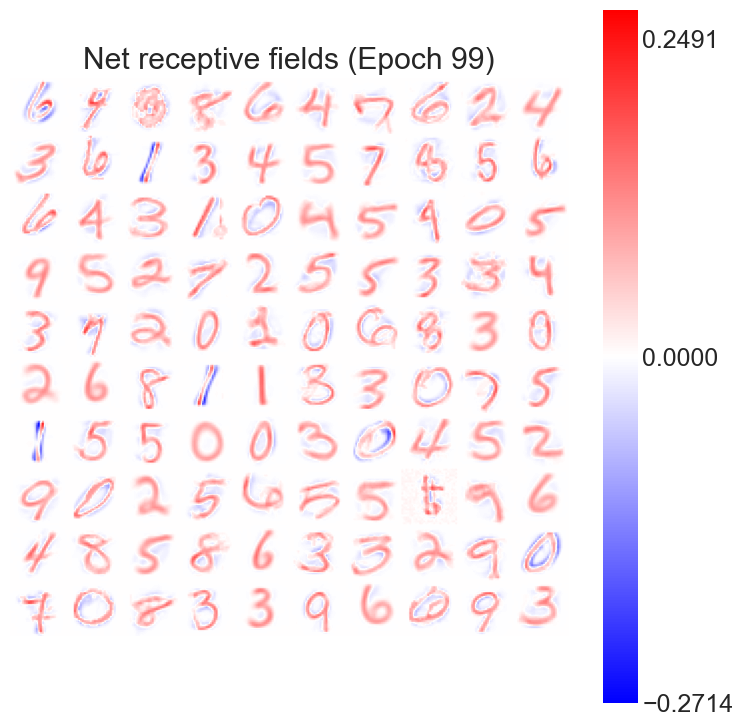

Saving weights...Done!


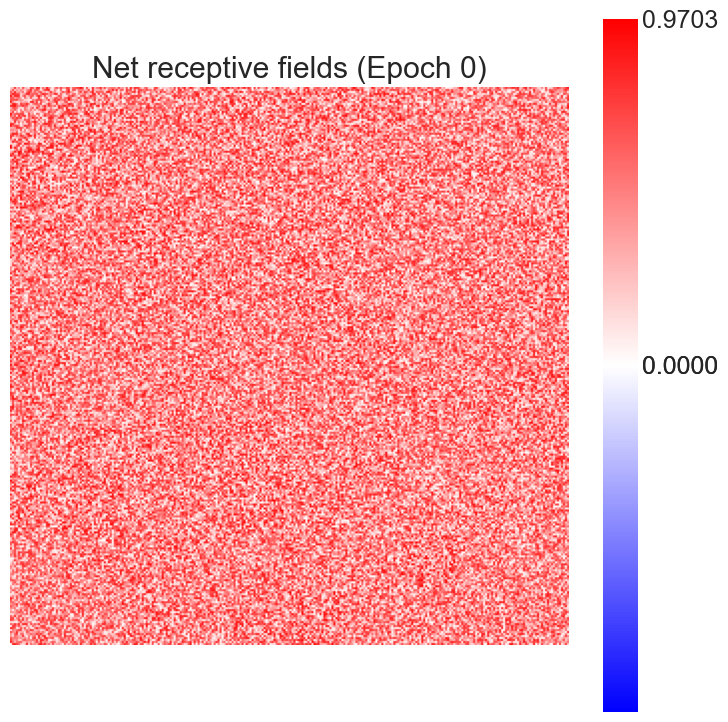

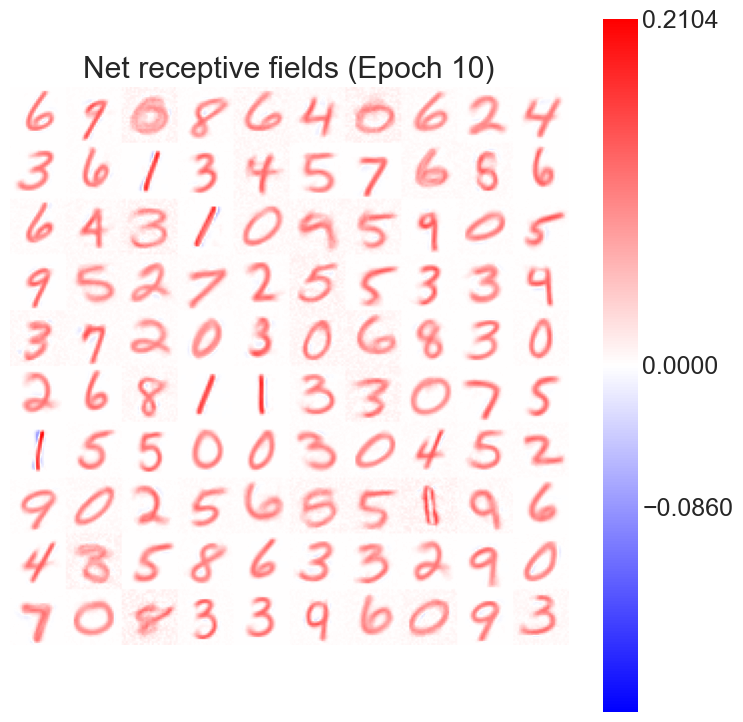

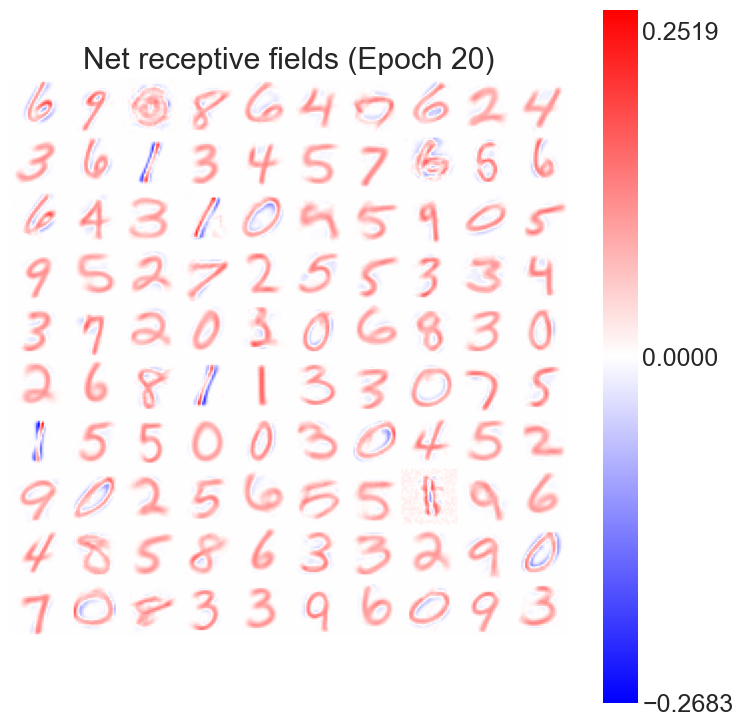

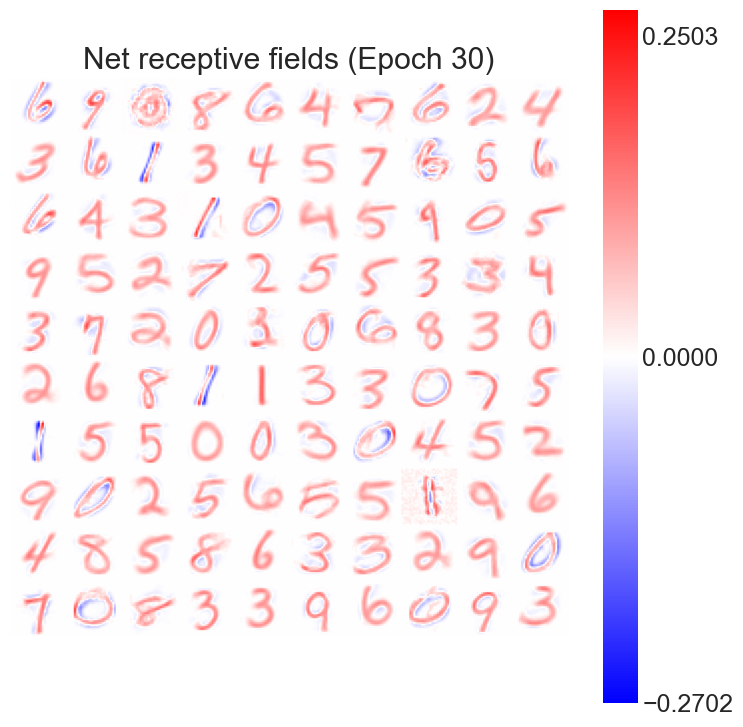

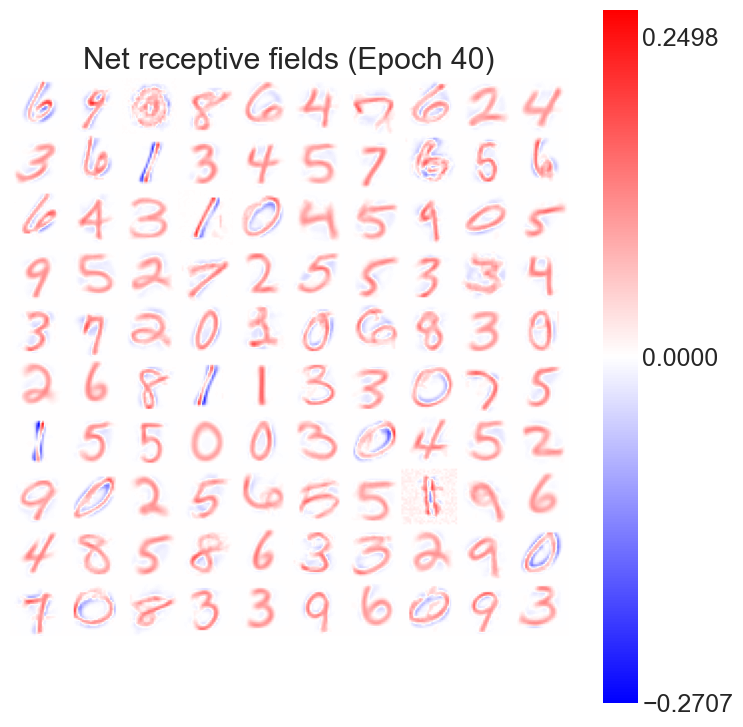

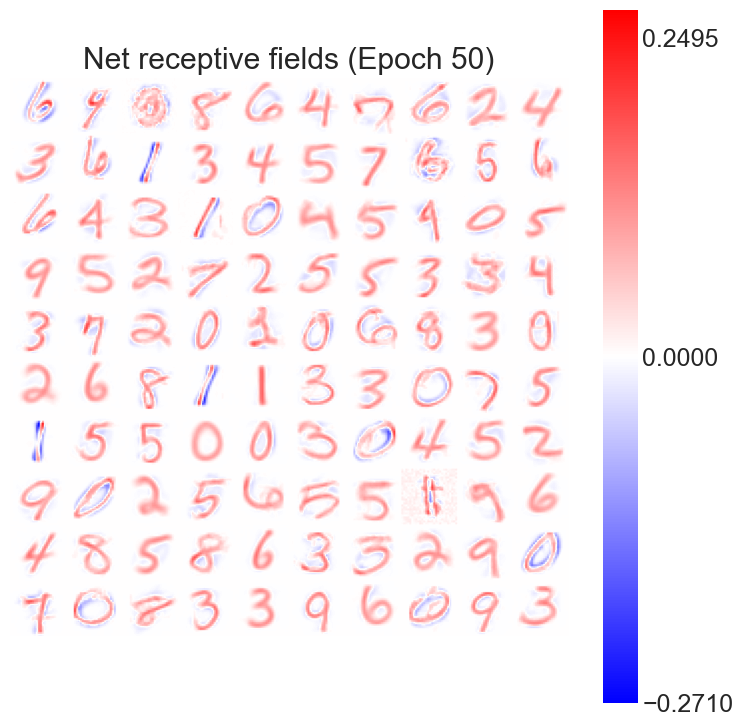

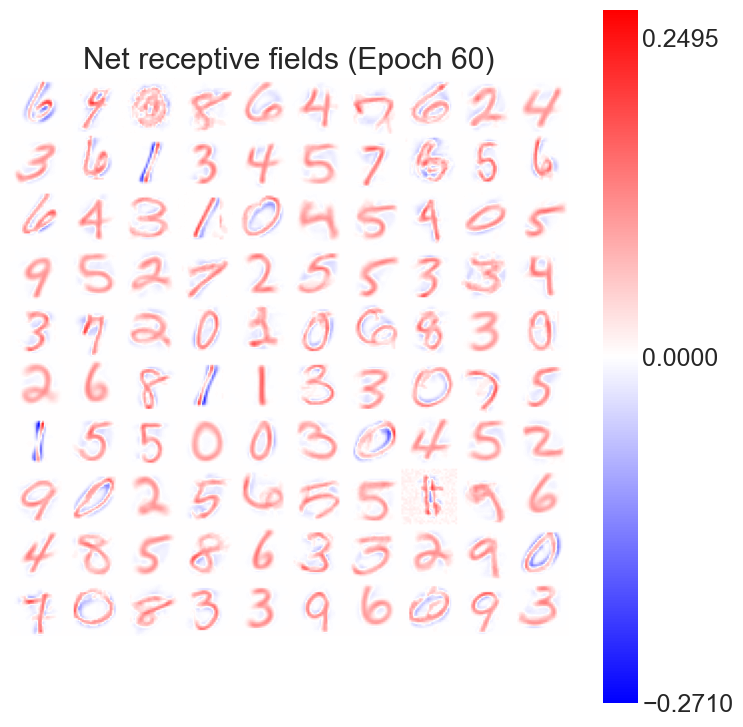

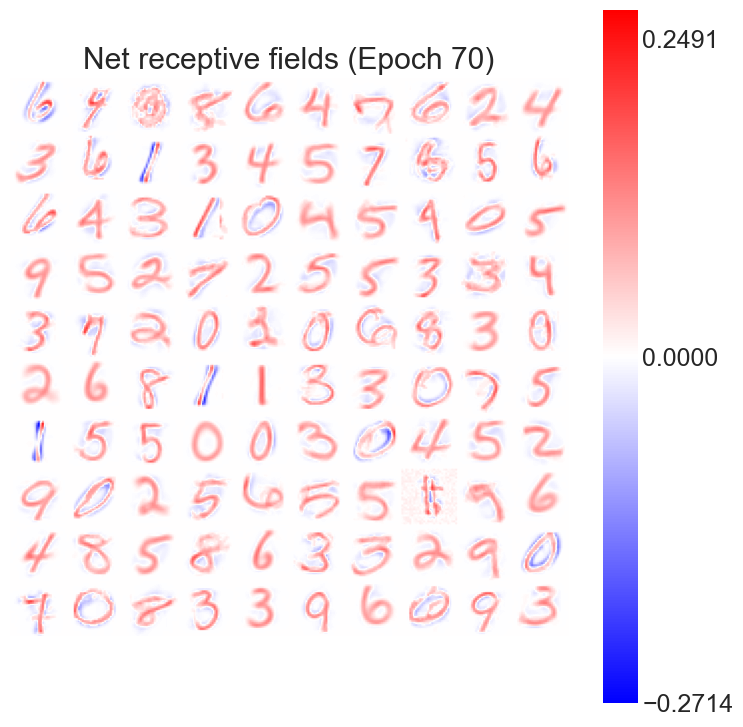

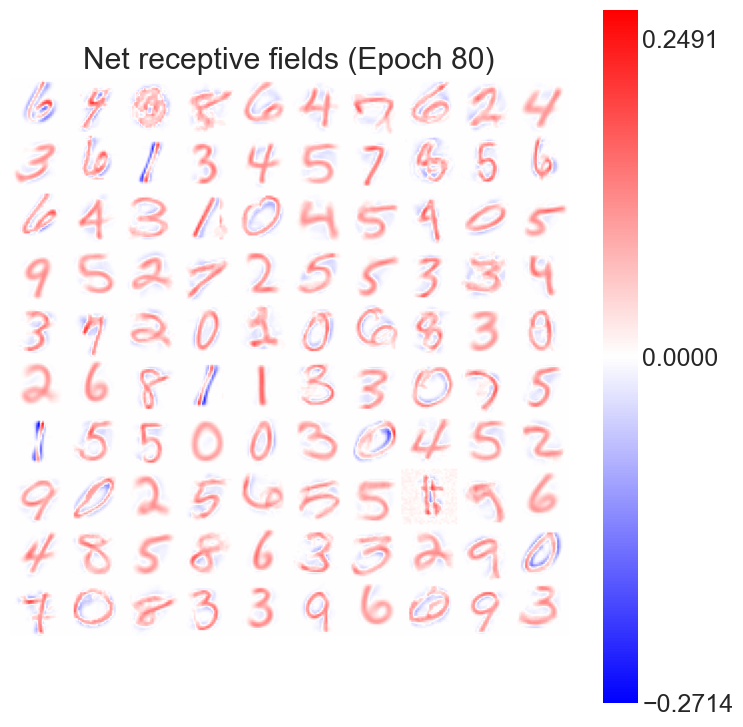

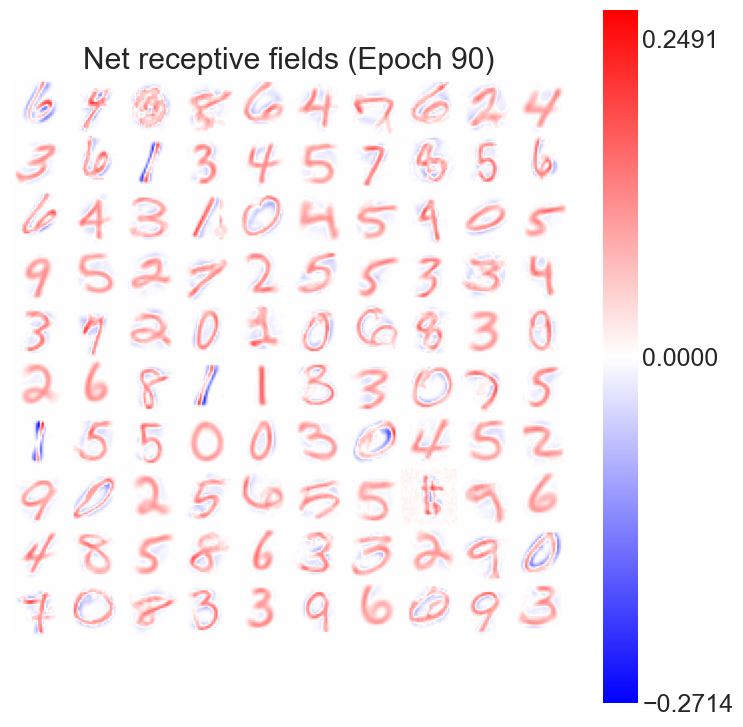

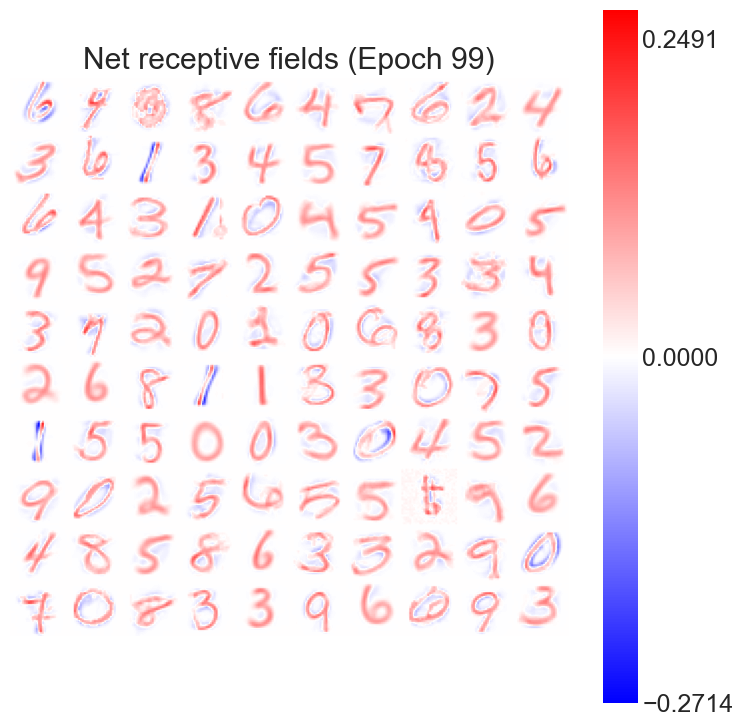

In [11]:
from mnist import get_mnist
x_train, y_train, x_test, y_test, x_val, y_val = get_mnist(2000)

# quick test 
x_train.shape

net = HebbNet(x_train.shape[1], 500 ,inhib_value= 0.4)
net.fit(x_train, 100, 500, 1e-2, True, print_every= 10)



### 2e. Plot final Competitive Hebbian network weights

Use `draw_grid_image` to create a plot of the weights of 100 neurons (e.g. in a 10x10 grid).

In [12]:
from viz import draw_grid_image



In [13]:
wts = np.load('export/wts.npy')
wts.shape

(784, 500)

### 2f. Questions

**Question 4:** Do the network weights exactly match specific samples in the dataset? Why or why not?

**Question 5:** Interpret the meaning of the positive and negative values within the same neuron's weights. How do these factors affect processing? It might be helpful to refer to specific example(s) in your visualization.

**Question 6:** Train your network when the competition is "winner-take-all" — the winner gets activation 1 and every other neuron gets activation 0. Generate a plot of the weights. How are they qualitatively different from before? *You shouldn't need to train for long to see the difference.*

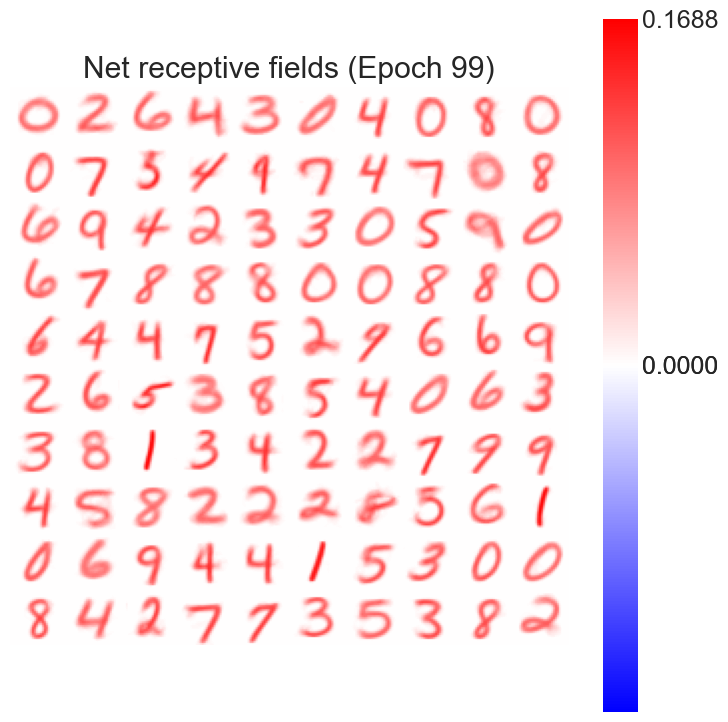

Saving weights...Done!


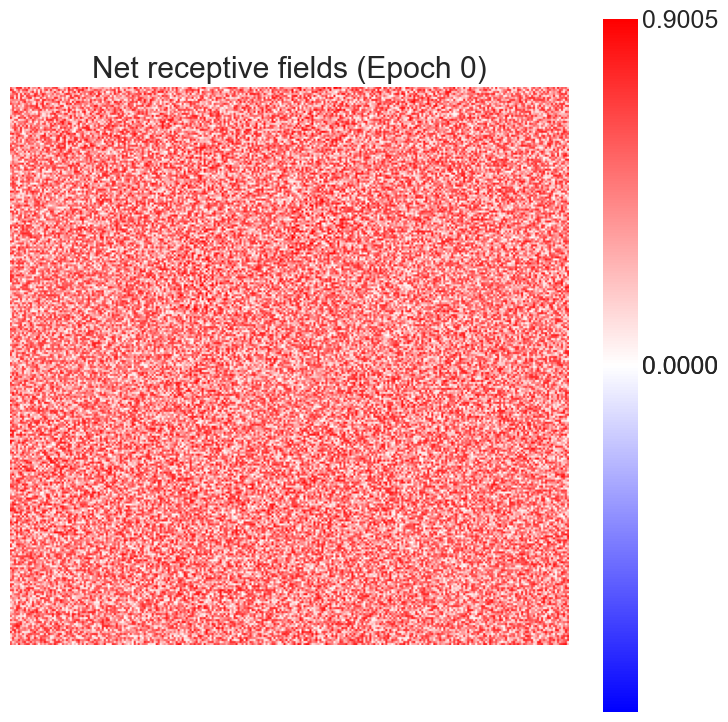

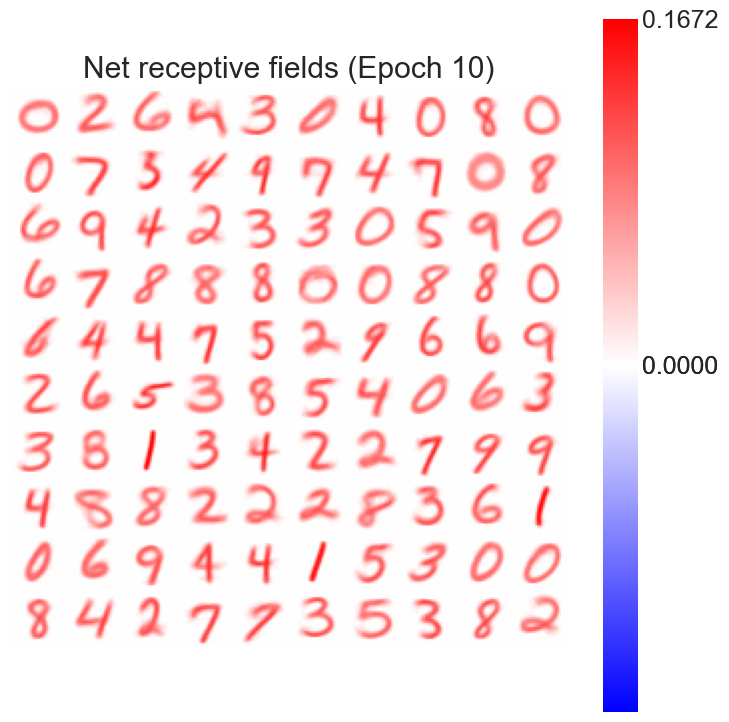

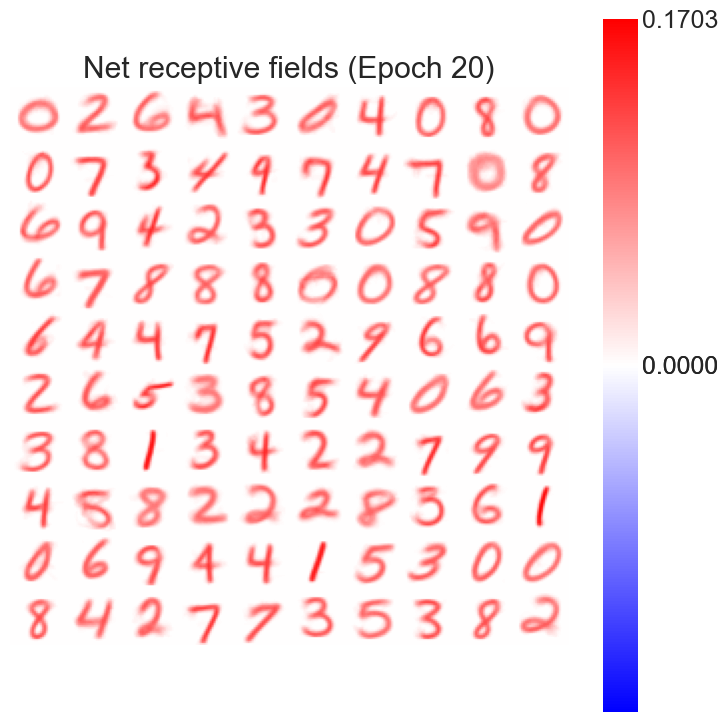

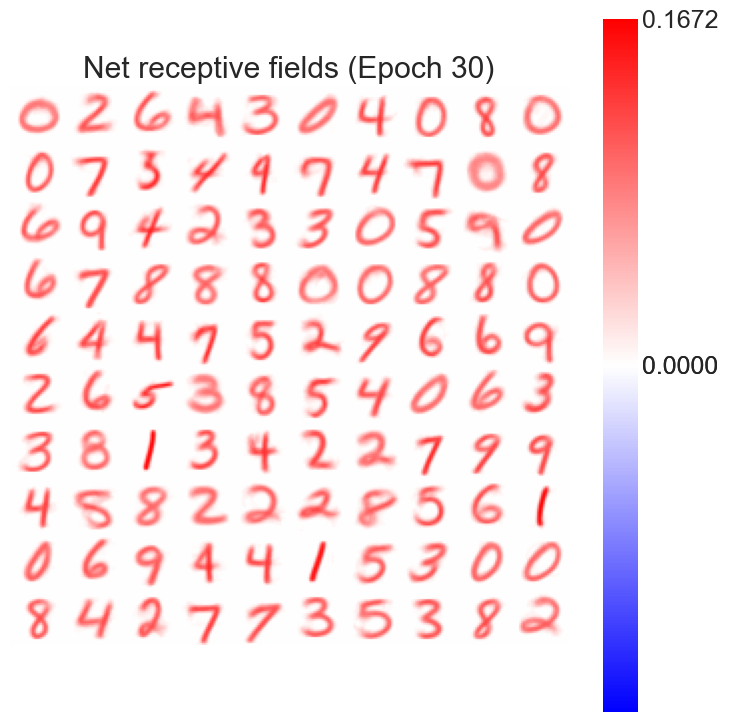

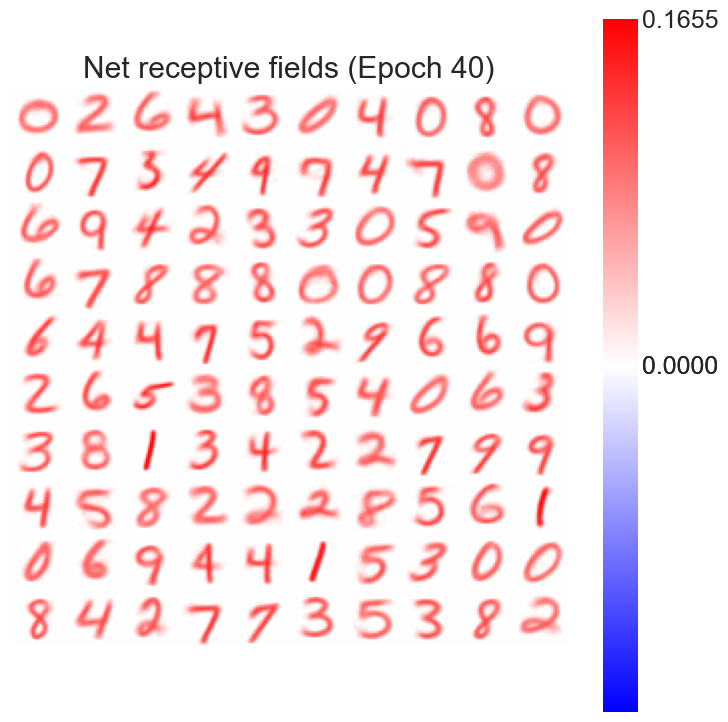

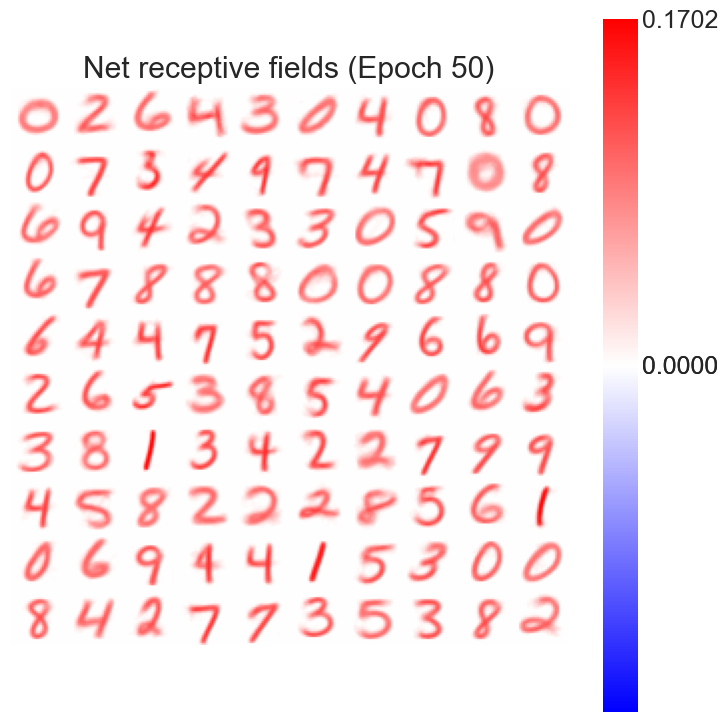

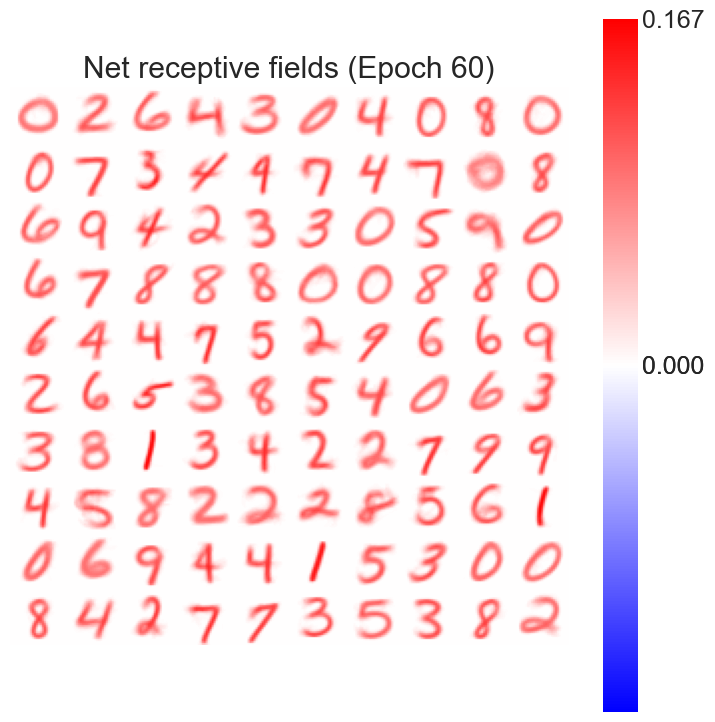

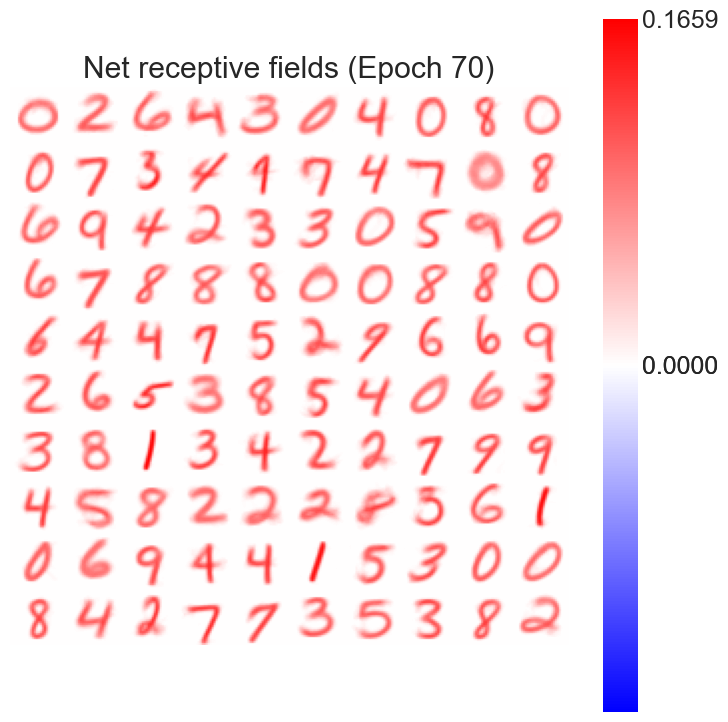

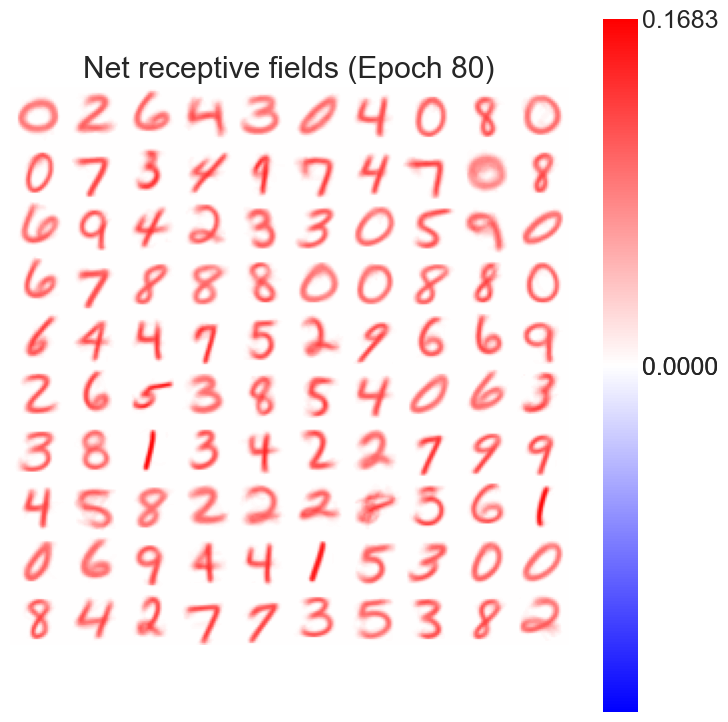

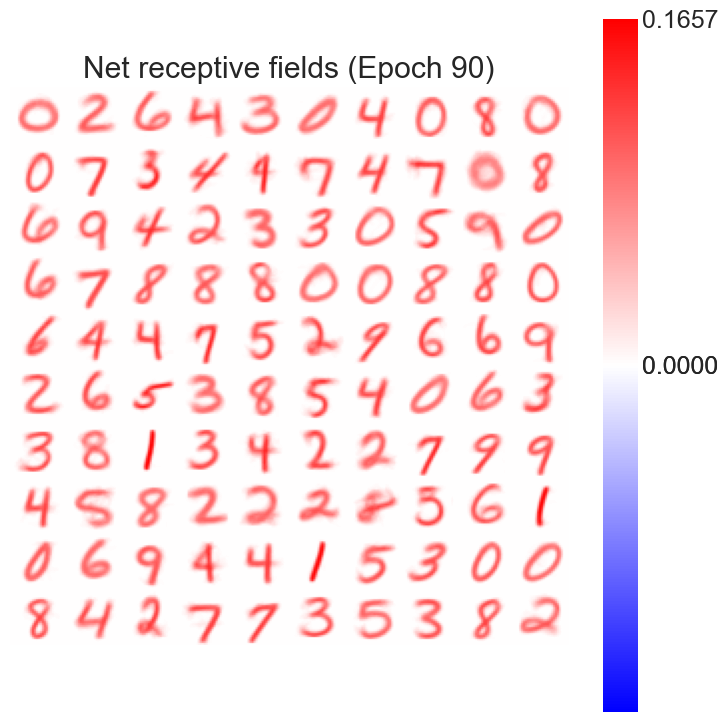

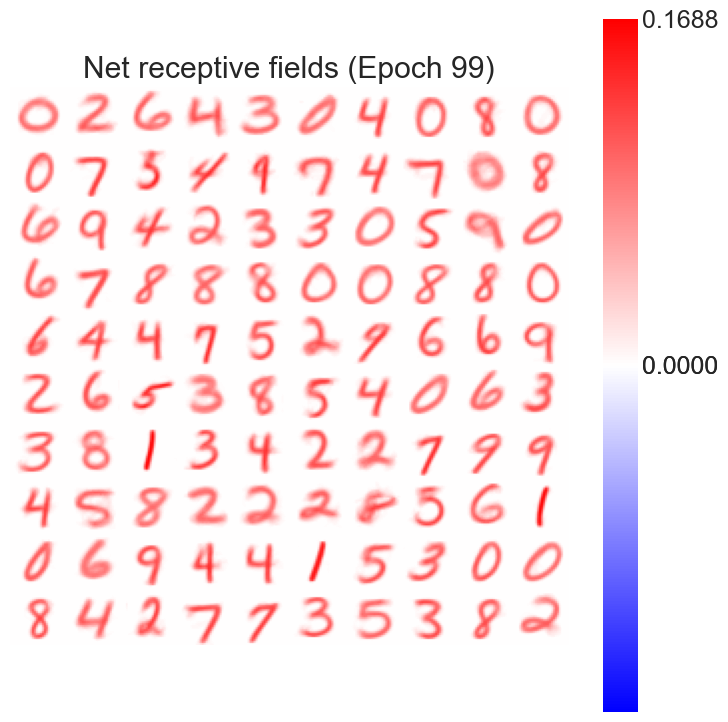

In [14]:
#Question 6, gamma = 0

net = HebbNet(x_train.shape[1], 500 ,inhib_value= 0.0)
net.fit(x_train, 100, 500, 1e-2, True, print_every= 10)


**Answer 4:** 

It seems they dont represent specific samples, but specific types of samples. For example, if someone writes their 2 with a loop, those would be picked up more strongly by a neuron with weights shaped like a 2 with a loop than one with a harder corner on the 2. 

**Answer 5:** 

Positive values of the weights mean that it is more likely that samples of the type that the neuron is "good" will appear in those features. Negative values mean that it is less likely that samples of the type that a neuron is "good" at will appear in the other part.

**Answer 6:** 

With a winner take all training strategy ($\Delta = 0$), there are no inhibitions so we don't see the negative effect of that in the results. we don't see the blue marks which are the the inhibitions. 